In [1]:
#!pip install python-dateutil==2.5.0
#!pip install pandas --ignore-installed
#!pip install seaborn --ignore-installed

In [3]:

import pandas as pd
import seaborn as sns
import numpy as np
from bemppUQ.utils.mie import bhmie
from bemppUQ.config import config
from bemppUQ.utils.login import tensorize

number_of_angles = 3601

angles = config['angles']
k_ext, k_int = config["k_ext"], config["k_int"]
lambda_par, freq = config["lambda"], config["frequency"]
polarization = config["polarization"]
direction = config["direction"]

eps_rel = config["eps_rel"]
mu_rel = config["mu_rel"]

n = k_int / k_ext
refIndex = n
numAngles = 901
s1,s2,qext,qsca,qback,gsca=bhmie(k_ext,k_int / k_ext,numAngles)

u =  4 * np.pi * s1
precision_list = [1, 2, 5, 10, 20, 30, 40, 50,60]

uh_list = []
h_list = []
N_list = []

for precision in precision_list:
    name = (
    "results/"
        + "precision"
    + str(precision)
    )

    my_dict = np.load(name + '.npy', allow_pickle = True, encoding = 'latin1')
    
    uh = my_dict.item().get('A22')[:1801]
    h = my_dict.item().get('h')
    N = my_dict.item().get('N')
    
    uh_list.append(uh)
    h_list.append(h)
    N_list.append(N)
    
    

df = pd.DataFrame(columns = ['precision', 'angle', 'cs', 'case', 'h'])

i = 0
err = []
Err = []

for precision in precision_list:
    uh = uh_list[i]
    
    h = h_list[i]
       
    
    U = tensorize(u, u)
    Uh = tensorize(uh, uh)
    
    rel_error = np.linalg.norm(uh - u) / np.linalg.norm(u)
    Rel_error = np.linalg.norm(Uh - U) / np.linalg.norm(U)
    
    err.append(rel_error)
    Err.append(Rel_error)
    
    i += 1

err = np.array(err)
Err = np.array(Err)
h_list = np.array(h_list)    

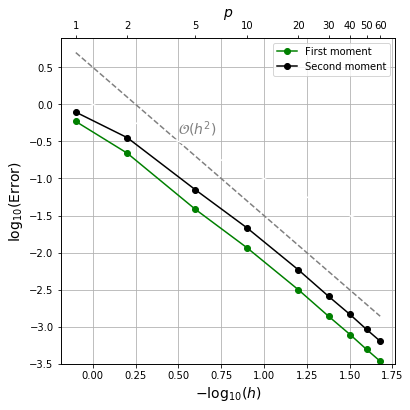

In [48]:
from matplotlib import pyplot as plt 

fig, ax  = plt.subplots(1,1, figsize=(6,6))

logh = np.log10(h_list)
logerr = np.log10(err)
Logerr = np.log10(Err)

ax.plot(-logh, logerr, marker='o', label = 'First moment', color = 'g')
ax.plot(-logh, Logerr, marker='o', label = 'Second moment', color = 'k')
ax.plot(-logh,  .5 + 2 * logh, color = 'gray', linestyle= '--')

plt.text(.5, -0.4,r'$\mathcal{O}(h^2)$', fontsize=14, color='gray')
ax2 = ax.twiny()
ax2.plot(-logh, logh, color='w')
ax2.set_xticks(-logh)
ax2.set_xticklabels(precision_list)
ax.legend()#prop={'size': 14})
ax.grid()
plt.ylim(-3.5,.9)
ax.set_xlabel(r'$-\log_{10}(h)$', fontsize=14)
ax2.set_xlabel(r'$p$', fontsize=14)
ax.set_ylabel(r'$\log_{10}($Error$)$', fontsize=14)
plt.savefig('plots/FirstSecond.pdf')

In [5]:
def get_error(L0, L):
    n = 1801
    Sigma_hat = np.zeros([n, n], dtype=np.complex128)
    N_hat = 0
    N_max = 0

    for l in range(0, L+1-L0):   
        i0 = L0 + l
        i1 = L - l
        if i0 <= i1:
            N0 = N_list[i0]
            N1 = N_list[i1]
            u0 = uh_list[i0]
            u1 = uh_list[i1]
            
            Temp = np.dot(np.array([u0]).T, np.array([u1]).conj())
            Sigma_hat += Temp
            if i0 != i1:
                Sigma_hat += Temp.conj().T
            N_hat += N0 * N1
            N_max = np.max([N_max, N0 * N1])


    for l in range(0, L-L0):
        i0 = L0 + l
        i1 = L - l - 1 
        if i0 <= i1:
            N0 = N_list[i0]
            N1 = N_list[i1]

            u0 = uh_list[i0]
            u1 = uh_list[i1]
            
            Temp = np.dot(np.array([u0]).T, np.array([u1]).conj())
            Sigma_hat -= Temp
            if i0 != i1:
                Sigma_hat -= Temp.conj().T

            N_hat += N0 * N1
            N_max = np.max([N_max, N0 * N1])
        
    Sigma = tensorize(u, u)
    
    Error = np.linalg.norm(Sigma_hat - Sigma) / np.linalg.norm(Sigma)
    return Error, N_hat, N_max
        
Lmax = len(precision_list)
L0 = 1

Err_hat = []
h_S = []
N_hat_list = []
N_max_list = []

for l in range(L0, Lmax):
    h_S.append(h_list[l])
    Error, N_hat, N_max = get_error(L0, l)
    Err_hat.append(Error)
    N_hat_list.append(N_hat)
    N_max_list.append(N_max)    

h_S = np.array(h_S)
Err_hat = np.array(Err_hat)

N_list = np.array(N_list)
N_hat_list = np.array(N_hat_list)
N_max_list = np.array(N_max_list)
print(h_S, Err_hat)    

[0.62831853 0.25132741 0.12566371 0.06283185 0.0418879  0.03141593
 0.02513274 0.02094395] [0.3549188  0.10116926 0.03089881 0.00974064 0.00374373 0.00187781
 0.00110076 0.00072307]


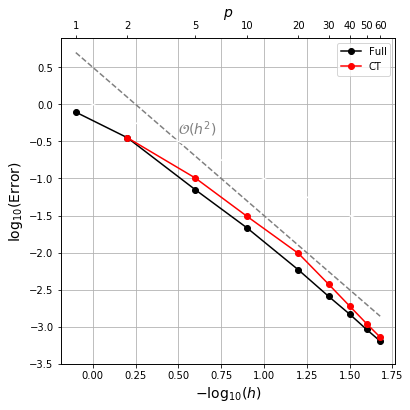

In [47]:
from matplotlib import pyplot as plt 

fig, ax  = plt.subplots(1,1, figsize=(6,6))
logh_S = np.log10(h_S)
Logerr_hat = np.log10(Err_hat)

ax.plot(-logh, Logerr, marker='o', label = 'Full', color = 'k')

ax.plot(-logh_S, Logerr_hat, marker='o', label = 'CT', color = 'r')


ax.plot(-logh,  .5 + 2 * logh, color = 'gray', linestyle= '--')#, label = r'$\mathcal{O}(h^2)$')

#plt.loglog(1/h_list,  1.5 * h_list ** 2, color = 'gray', linestyle= '--')

ax2 = ax.twiny()

ax2.plot(-logh, logh, color='w')
ax2.set_xticks(-logh)
ax2.set_xticklabels(precision_list)
plt.text(.5, -0.4,r'$\mathcal{O}(h^2)$', fontsize=14, color='gray')

plt.ylim(-3.5,.9)
ax.legend()#prop={'size': 14})
ax.grid()
#plt.grid(color='gray', linestyle='dashed', which='both')
ax.set_xlabel(r'$-\log_{10}(h)$', fontsize=14)
ax2.set_xlabel(r'$p$', fontsize=14)
ax.set_ylabel(r'$\log_{10}($Error$)$', fontsize=14)

plt.savefig('plots/Secondh.pdf')

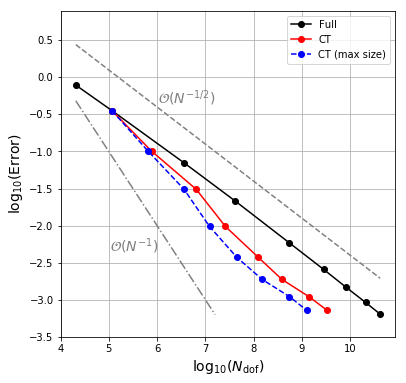

In [49]:
from matplotlib import pyplot as plt 

fig, ax  = plt.subplots(1,1, figsize=(6,6))
logh_S = np.log10(h_S)
Logerr_hat = np.log10(Err_hat)

logN_hat = np.log10(N_hat_list)
logN_max = np.log10(N_max_list)
N2 = N_list ** 2
logN2 = np.log10(N2)
logN2 = np.log10(N2)

ax.plot(logN2, Logerr, marker='o', label = 'Full', color = 'black')

ax.plot(logN_hat, Logerr_hat, marker='o', label = 'CT', color = 'r')

ax.plot(logN_max, Logerr_hat, marker='o', label = 'CT (max size)', color = 'b', linestyle='--')


ax.plot(logN2,  -logN2/2 + 2.6,  color = 'gray', linestyle= '--')#, label = )

test = np.array([ 4.31672498,  5.06805221,  6.55842103, 7.2])
ax.plot(test, -test +4,  color = 'gray', linestyle= 'dashdot')#, label = r'$\mathcal{O}(N^{-1})$')

plt.text(6.02,-.35,r'$\mathcal{O}(N^{-1/2})$', color='gray', fontsize=14)
plt.text(5.02,-2.35,r'$\mathcal{O}(N^{-1})$', color='gray', fontsize=14)

#ax2 = ax.twiny()

#ax2.plot(-logh, logN2, color='w')
#ax2.set_xticks(-logN2)
#ax2.set_xticklabels(precision_list)

plt.ylim(-3.5,.9)

ax.legend()#prop={'size': 14})
ax.grid()
#plt.grid(color='gray', linestyle='dashed', which='both')
ax.set_xlabel(r'$\log_{10}(N_\mathrm{dof})$', fontsize=14)
ax2.set_xlabel(r'$p$', fontsize=14)
ax.set_ylabel(r'$\log_{10}($Error$)$', fontsize=14)
plt.savefig('plots/SecondDof.pdf')

In [8]:
precision_list = np.array(precision_list)
precdof = precision_list[L0:]
levels = np.arange(precision_list.shape[0])
Edof = Err[L0:] / N2[L0:]
Edof_hat = Err_hat / N_hat_list
Edof_max = Err_hat / N_max_list
compression_hat = Edof / Edof_hat
compression_max = Edof / Edof_max

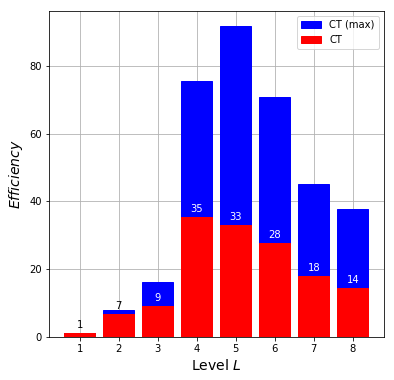

In [9]:
fig, ax  = plt.subplots(1,1, figsize=(6,6))

ax.bar(np.arange(precdof.shape[0]),1/compression_max, color = 'b', edgecolor='b', label='CT (max)',zorder=3)
ax.bar(np.arange(precdof.shape[0]),1/compression_hat, color = 'r', edgecolor='r', label='CT',zorder=3)

ax.set_xticks(np.arange(precdof.shape[0]))
ax.set_xticklabels(levels[L0:])
ax.set_xlabel(r'Level $L$', fontsize=14)
ax.set_ylabel(r'$Efficiency$', fontsize=14)
ax.grid(zorder=0)
ax.legend()
plt.plot()

for i in range(compression_max.shape[0]):
    xval = i 
    yval = (1/compression_hat)[i] + .5
    if i >= 2:
        col = 'w'
    else:
        col = 'k'
    plt.text(xval, yval + 1, str(int(yval)), ha='center', color = col)
    
plt.savefig('plots/SecondEfficiency.pdf')    

/usr/local/lib/python3.5/dist-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"


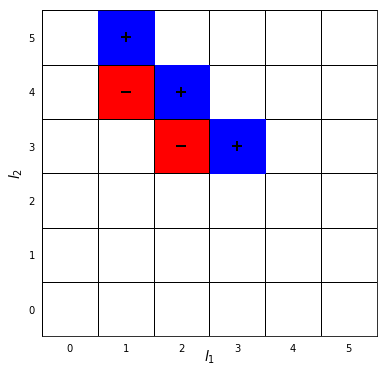

In [54]:
# -*- coding: utf-8 -*-

import matplotlib.patches as patches
Lmax = 5

color_bc = 'b'#tuple(np.array([52,86,140])/255)
color_yc = 'r'#tuple(np.array([252,187,45])/255)

l0 = np.arange(Lmax+1)
l1 = np.arange(Lmax+1)

alpha = ["%i" % z for z in l0]
alpha_val = l0

fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.xaxis.labelpad = -5
for l0 in range(Lmax+1):
  for l1 in range(Lmax+1):
    ax.add_patch(patches.Rectangle((l0, l1), 1, 1, fill=False, edgecolor='k'))

for l0 in range(Lmax+1):
  for l1 in range(Lmax+1):
    if (l1 == Lmax+L0-l0 ) and (l1 >= l0):
      ax.add_patch(patches.Rectangle((l0 ,l1), 1, 1 , fill='False', color=color_bc, edgecolor='k'))
      plt.plot(l0+0.5, l1+0.5, '+', mew=2, ms=10, color='black')


for l0 in range(Lmax):
  for l1 in range(Lmax):
    if (l1 == Lmax+L0-l0-1 ) and (l1 >= l0):
      ax.add_patch(patches.Rectangle((l0 ,l1), 1, 1 , fill='False', facecolor=color_yc, edgecolor='k'))
      plt.plot(l0+0.5, l1+0.5, '_', mew=2, ms=10, color='black')


plt.xlim(0, Lmax+1)
plt.ylim(0, Lmax+1)

plt.xlabel(r"$ l_1$", fontsize=14)
plt.ylabel(r"$ l_2$", fontsize=14)

ax.set_xticklabels(alpha)#, fontsize=14)
ax.set_yticklabels(alpha)#, fontsize=14)
ax.set_xticks(alpha_val+0.5)
ax.set_yticks(alpha_val+0.5)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

plt.savefig('plots/combVsSym0.pdf')

plt.show(block=False)